In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
from datetime import timedelta
from datetime import datetime
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
inspector = inspect(engine)
columns =inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [11]:
# Calculate the date 1 year ago from the last data point in the database
lastdatadt =  session.query(Measurement.date).order_by(Measurement.date.desc()).first()
lastdatadt = list(np.ravel(lastdatadt))[0]
lastdatadt = dt.datetime.strptime(lastdatadt, '%Y-%m-%d')
lastdatadt

datetime.datetime(2017, 8, 23, 0, 0)

In [12]:
Year = int(dt.datetime.strftime(lastdatadt, '%Y'))
Month = int(dt.datetime.strftime(lastdatadt, '%m'))
Day = int(dt.datetime.strftime(lastdatadt, '%d'))

yearbeforedt = dt.date(Year, Month, Day) - dt.timedelta(days = 365)
print("One Year ago:", yearbeforedt)

One Year ago: 2016-08-23


In [13]:
# Perform a query to retrieve the data and precipitation scores
PrecipitationData= session.query(Measurement.date, Measurement.prcp).\
                                filter(Measurement.date >= yearbeforedt).\
                                order_by(Measurement.date.desc()).all()
for data in PrecipitationData:
    print(data)

('2017-08-23', 0.0)
('2017-08-23', 0.0)
('2017-08-23', 0.08)
('2017-08-23', 0.45)
('2017-08-22', 0.0)
('2017-08-22', 0.0)
('2017-08-22', 0.5)
('2017-08-21', 0.0)
('2017-08-21', 0.02)
('2017-08-21', None)
('2017-08-21', 0.56)
('2017-08-20', 0.0)
('2017-08-20', 0.01)
('2017-08-20', None)
('2017-08-19', 0.0)
('2017-08-19', 0.0)
('2017-08-19', None)
('2017-08-19', 0.09)
('2017-08-18', 0.0)
('2017-08-18', 0.0)
('2017-08-18', 0.06)
('2017-08-18', None)
('2017-08-17', 0.0)
('2017-08-17', 0.05)
('2017-08-17', 0.01)
('2017-08-17', 0.13)
('2017-08-16', 0.0)
('2017-08-16', 0.07)
('2017-08-16', 0.12)
('2017-08-16', 0.42)
('2017-08-15', 0.02)
('2017-08-15', 0.0)
('2017-08-15', 0.06)
('2017-08-15', 0.32)
('2017-08-15', 0.42)
('2017-08-14', 0.0)
('2017-08-14', 0.01)
('2017-08-14', 0.08)
('2017-08-14', 0.0)
('2017-08-14', 0.22)
('2017-08-13', 0.0)
('2017-08-13', None)
('2017-08-13', 0.0)
('2017-08-13', 0.0)
('2017-08-13', None)
('2017-08-12', 0.0)
('2017-08-12', 0.0)
('2017-08-12', 0.14)
('2017-08-11'

In [14]:
# Save the query results as a Pandas DataFrame and set the index to the date column
PrecipitationData_df = pd.DataFrame(PrecipitationData)
PrecipitationData_df.set_index('date', inplace = True)
# Sort the dataframe by date
PrecipitationData_df.sort_values('date', ascending = True, inplace= True)
PrecipitationData_df.head()

,prcp
date,
2016-08-23,0.70
2016-08-23,0.00
2016-08-23,0.15
2016-08-23,1.79
2016-08-23,NaN


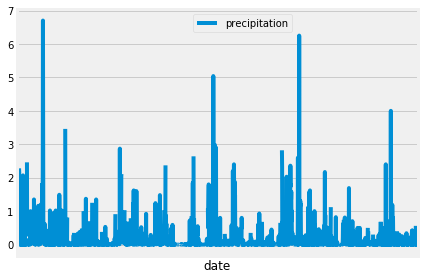

In [15]:
#Use Pandas Plotting with Matplotlib to plot the data
PrecipitationData_df.plot()
plt.xticks([])
plt.legend(['precipitation'], bbox_to_anchor=(0.7,1))
#plt.figure(figsize=(10,8))
#plt.show()
plt.tight_layout()

In [16]:
# Use Pandas to calcualte the summary statistics for the precipitation data
PrecipitationData_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [17]:
# Design a query to show how many stations are available in this dataset?
station_count = session.query(Station).count()
print(f'There are {station_count} stations')

There are 9 stations


In [18]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_stations=session.query(Measurement.station, func.count(Measurement.station)).\
                             group_by(Measurement.station).\
                             order_by(func.count(Measurement.station).desc()).all()
for stations in active_stations:
    print(stations)

('USC00519281', 2772)
('USC00519397', 2724)
('USC00513117', 2709)
('USC00519523', 2669)
('USC00516128', 2612)
('USC00514830', 2202)
('USC00511918', 1979)
('USC00517948', 1372)
('USC00518838', 511)


In [19]:
stationid= active_stations[0][0]
stationid
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
lowtemp=session.query(func.min(Measurement.tobs)).\
                      filter(Measurement.station == stationid).all()
lowtemp=lowtemp[0][0]
hightemp=session.query(func.max(Measurement.tobs)).\
                     filter(Measurement.station == stationid).all()
hightemp=hightemp[0][0]
avgtemp=session.query(func.avg(Measurement.tobs)).\
                      filter(Measurement.station == stationid).all()
avgtemp=avgtemp[0][0]

print(f'The lowest temp is {lowtemp} degrees')
print(f'The highest temp is {hightemp} degrees')
print(f'The average temp is {avgtemp} degrees')

The lowest temp is 54.0 degrees
The highest temp is 85.0 degrees
The average temp is 71.66378066378067 degrees


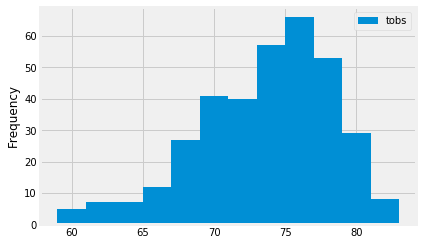

In [20]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
station_temp=session.query(Measurement.date, Measurement.tobs).\
                          filter(Measurement.date >= yearbeforedt, Measurement.station == stationid).all()
#for temp in station_temp:
 #   print(temp)
station_temp_df= pd.DataFrame(station_temp)

station_temp_df.plot.hist(bins=12)

In [21]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [22]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
temps= calc_temps('2016-08-23', '2017-08-23')
temps = temps[0]
temps

(58.0, 74.59058295964125, 87.0)

In [23]:
low=temps[0]
avg = temps[1]
high = temps[2]

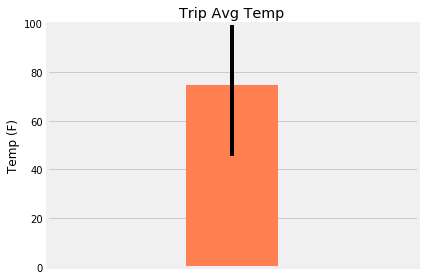

In [24]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
plt.bar(1, avg, yerr = high-low, color= 'coral', width=0.5)
plt.xlim(0,2)
plt.xticks([])
plt.ylim([0,100])
plt.title('Trip Avg Temp')
plt.ylabel('Temp (F)')
plt.tight_layout()

In [25]:
inspector = inspect(engine)
columns =inspector.get_columns('station')
for c in columns:
    print(c['name'], c['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [26]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
start='2016-08-23'
end='2017-08-23'
,
station_totals= session.query(Measurement.station, func.sum(Measurement.prcp), Station.name, Station.latitude, Station.longitude, Station.elevation).\
             filter(Measurement.station == Station.station).\
             filter(Measurement.date >= start).filter(Measurement.date <= end).\
             group_by(Station.station).\
             order_by(func.sum(Measurement.prcp).desc()).all()

for rain_totals in station_totals:
    print(rain_totals)

('USC00516128', 147.81000000000006, 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4)
('USC00519281', 70.03000000000003, 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9)
('USC00513117', 48.510000000000026, 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6)
('USC00519523', 38.01, 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5)
('USC00514830', 33.239999999999995, 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0)
('USC00519397', 16.089999999999986, 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0)
('USC00517948', 4.59, 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9)


## Optional Challenge Assignment

In [27]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [28]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
#normals=[]

    
# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date

In [29]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [30]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [31]:
# Plot the daily normals as an area plot with `stacked=False`
